In [6]:
import os
import tensorflow as tf
import numpy as np
import math
from random import sample, shuffle
from PIL import Image
import matplotlib.pyplot as plt
from src.DataGenerator import AudioDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Reshape, Conv2DTranspose, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns

In [7]:
data_gen = AudioDataGenerator(
    directory='data/Spotify/comp_pngs/', 
    image_size=(128,512), 
    color_mode='rgb',
    batch_size=64,
    sample_size=100000,
    shuffle=True,
    train_test_split=True, 
    test_size=0.02,
    output_channel_index=0,
    output_size=(128,64))



Found 98000 files for Training set
Found 2000 files for Test set


In [8]:
prediction_gen = AudioDataGenerator(
    directory='data/Spotify/comp_pngs/', 
    image_size=(128,512),
    color_mode='rgb',
    batch_size=1,
    shuffle=False,
    output_channel_index=0,
    output_size=(128,64))


Found 278326 files for Generator set


In [15]:
img_width = 64
img_height = 128
kernel_size = (3,3)
strides = (2,2)


class Autoencoder(tf.keras.Model):
    
    def __init__(self, latent_dim, num_channels):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Sequential([
            Conv2D(input_shape=(img_height, img_width, num_channels), filters=32, kernel_size=kernel_size, padding="same", strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Conv2D(filters=64, kernel_size=kernel_size, padding="same", strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Conv2D(filters=128, kernel_size=kernel_size, padding="same", strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Conv2D(filters=256, kernel_size=kernel_size, padding="same",strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Conv2D(filters=512, kernel_size=kernel_size, padding="same",strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Conv2D(filters=1024, kernel_size=kernel_size, padding="same",strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Flatten(),
            Dense(units=latent_dim,)
        ])
        self.decoder = Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            Dense(units=2048, activation='relu'),
            BatchNormalization(axis=-1),
            Reshape(target_shape=(2,1,1024)),
            Conv2DTranspose(filters=1024, kernel_size=kernel_size, strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=512, kernel_size=kernel_size, strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=256, kernel_size=kernel_size, strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=128, kernel_size=kernel_size, strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=64, kernel_size=kernel_size,  strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=32, kernel_size=kernel_size,  strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=num_channels, kernel_size=kernel_size, padding="same", activation='sigmoid'),
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = Autoencoder(64, 1)

opt = Adam(learning_rate=1e-3)

autoencoder.compile(optimizer=opt, loss=tf.keras.losses.mse)

In [ ]:
autoencoder.load('data/autoencoder_100k_1024f_mel_64')

In [ ]:
hist_2 = autoencoder.fit(data_gen.train,
                       batch_size=data_gen.batch_size,
                       epochs=15,
                       validation_data=data_gen.test)

Epoch 1/15
1238/1531 [=======================>......] - ETA: 4:16 - loss: 0.0081

In [128]:
autoencoder.save('data/autoencoder_100k_1024f_mel_64')

INFO:tensorflow:Assets written to: data/autoencoder_100k_512f_mel_128/assets


INFO:tensorflow:Assets written to: data/autoencoder_100k_512f_mel_128/assets


<Figure size 1440x360 with 0 Axes>

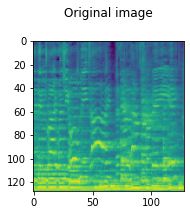

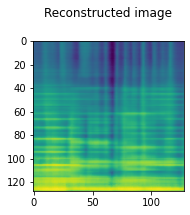

In [129]:
from src.helper_functions import plot_reconstruction

test_img = prediction_gen.take(1234)[0]
prediction = autoencoder(test_img)

plt.figure(figsize=(20,5))

plot_reconstruction(test_img, prediction, 1)

In [132]:
comp_data_gen = AudioDataGenerator(
    directory='data/Spotify/comp_pngs/', 
    image_size=(128,512), 
    color_mode='rgb',
    batch_size=64,
    sample_size=100000,
    shuffle=True,
    train_test_split=True, 
    test_size=0.02,
    output_size=(128,128))

comp_autoencoder = Autoencoder2(128, 3)

opt = Adam(learning_rate=1e-3)

comp_autoencoder.compile(optimizer=opt, loss=tf.keras.losses.mse)


Found 98000 files for Training set
Found 2000 files for Test set


In [ ]:
hist2 = comp_autoencoder.fit(comp_data_gen.train,
                       batch_size=comp_data_gen.batch_size,
                       epochs=10,
                       validation_data=comp_data_gen.test)

Epoch 1/10
1531/1531 [==============================] - 2906s 2s/step - loss: 0.0344 - val_loss: 0.0348
Epoch 2/10
1531/1531 [==============================] - 2167s 1s/step - loss: 0.0341 - val_loss: 0.0348
Epoch 3/10
1531/1531 [==============================] - 1961s 1s/step - loss: 0.0340 - val_loss: 0.0344
Epoch 4/10
1531/1531 [==============================] - 1925s 1s/step - loss: 0.0337 - val_loss: 0.0341
Epoch 5/10
1531/1531 [==============================] - 2225s 1s/step - loss: 0.0336 - val_loss: 0.0336
Epoch 6/10
 295/1531 [====>.........................] - ETA: 29:53 - loss: 0.0335

In [ ]:
test_img = comp_data_gen.take(0)[0]

prediction = comp_autoencoder(test_img)

plot_3channel_reconstruction_comparison(test_img, prediction, 3)

In [ ]:
comp_autoencoder.save('data/comp_autoencoder_mel_128')